# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

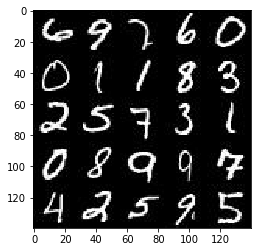

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

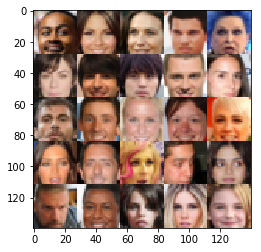

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/home/wendong/miniconda2/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, [], name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    lrelu = lambda x: tf.maximum(alpha * x, x)
        
    with tf.variable_scope('discriminator', reuse=reuse):
        #kernel_init = tf.random_normal_initializer(mean=0.0, stddev=0.02)
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        rx1 = lrelu(x1)
        
        x2 = tf.layers.conv2d(rx1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bx2 = tf.layers.batch_normalization(x2, training=True)
        rx2 = lrelu(bx2)
        
        x3 = tf.layers.conv2d(rx2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bx3 = tf.layers.batch_normalization(x3, training=True)
        rx3 = lrelu(bx3)
        
        x4 = tf.nn.dropout(rx3, 0.7)
        
        flat = tf.reshape(x4, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    lrelu = lambda x: tf.maximum(alpha * x, x)
        
    with tf.variable_scope('generator', reuse=not is_train):
        #kernel_init = tf.random_normal_initializer(mean=0.0, stddev=0.02)
        
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = lrelu(x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = lrelu(x2)

        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = lrelu(x3)
        
        x4 = tf.nn.dropout(x3, 0.7)
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                        labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                        labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                        labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    gen_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
    
    with tf.control_dependencies(gen_update_ops):       
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.1)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2
                steps += 1
                
                #random noise as input to discriminator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run opitimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 1.8725... Generator Loss: 0.3432
Epoch 1/2... Batch 20... Discriminator Loss: 2.2844... Generator Loss: 0.2448
Epoch 1/2... Batch 30... Discriminator Loss: 0.5051... Generator Loss: 2.8158
Epoch 1/2... Batch 40... Discriminator Loss: 0.8824... Generator Loss: 1.5296
Epoch 1/2... Batch 50... Discriminator Loss: 0.8048... Generator Loss: 1.7454
Epoch 1/2... Batch 60... Discriminator Loss: 1.6042... Generator Loss: 0.6135
Epoch 1/2... Batch 70... Discriminator Loss: 1.2796... Generator Loss: 0.8218
Epoch 1/2... Batch 80... Discriminator Loss: 1.1470... Generator Loss: 0.9614
Epoch 1/2... Batch 90... Discriminator Loss: 1.3623... Generator Loss: 1.7496
Epoch 1/2... Batch 100... Discriminator Loss: 1.3427... Generator Loss: 0.6793


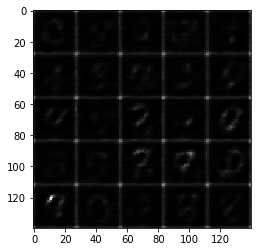

Epoch 1/2... Batch 110... Discriminator Loss: 1.3494... Generator Loss: 1.8855
Epoch 1/2... Batch 120... Discriminator Loss: 1.1138... Generator Loss: 1.5173
Epoch 1/2... Batch 130... Discriminator Loss: 1.1790... Generator Loss: 0.7824
Epoch 1/2... Batch 140... Discriminator Loss: 1.1634... Generator Loss: 0.8683
Epoch 1/2... Batch 150... Discriminator Loss: 1.0350... Generator Loss: 1.0156
Epoch 1/2... Batch 160... Discriminator Loss: 1.0125... Generator Loss: 1.1142
Epoch 1/2... Batch 170... Discriminator Loss: 1.1674... Generator Loss: 0.8234
Epoch 1/2... Batch 180... Discriminator Loss: 1.0189... Generator Loss: 1.2709
Epoch 1/2... Batch 190... Discriminator Loss: 1.1906... Generator Loss: 0.7089
Epoch 1/2... Batch 200... Discriminator Loss: 0.9874... Generator Loss: 1.2608


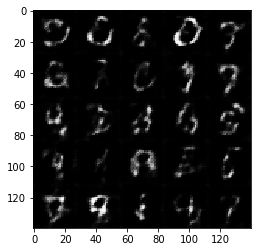

Epoch 1/2... Batch 210... Discriminator Loss: 1.0502... Generator Loss: 0.8603
Epoch 1/2... Batch 220... Discriminator Loss: 1.2189... Generator Loss: 1.7751
Epoch 1/2... Batch 230... Discriminator Loss: 1.0079... Generator Loss: 1.4041
Epoch 1/2... Batch 240... Discriminator Loss: 1.5869... Generator Loss: 2.3301
Epoch 1/2... Batch 250... Discriminator Loss: 1.4412... Generator Loss: 0.5014
Epoch 1/2... Batch 260... Discriminator Loss: 1.2074... Generator Loss: 0.7167
Epoch 1/2... Batch 270... Discriminator Loss: 1.1003... Generator Loss: 1.4241
Epoch 1/2... Batch 280... Discriminator Loss: 1.0494... Generator Loss: 1.0242
Epoch 1/2... Batch 290... Discriminator Loss: 1.2554... Generator Loss: 0.6396
Epoch 1/2... Batch 300... Discriminator Loss: 1.5809... Generator Loss: 0.3973


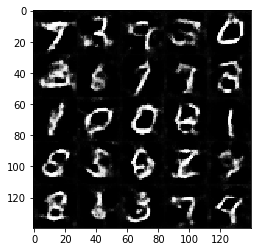

Epoch 1/2... Batch 310... Discriminator Loss: 1.1065... Generator Loss: 1.3189
Epoch 1/2... Batch 320... Discriminator Loss: 1.4244... Generator Loss: 2.2616
Epoch 1/2... Batch 330... Discriminator Loss: 1.0843... Generator Loss: 0.8875
Epoch 1/2... Batch 340... Discriminator Loss: 1.1817... Generator Loss: 0.8071
Epoch 1/2... Batch 350... Discriminator Loss: 1.2855... Generator Loss: 0.6319
Epoch 1/2... Batch 360... Discriminator Loss: 1.0394... Generator Loss: 0.9934
Epoch 1/2... Batch 370... Discriminator Loss: 1.5026... Generator Loss: 0.5240
Epoch 1/2... Batch 380... Discriminator Loss: 1.0854... Generator Loss: 1.9489
Epoch 1/2... Batch 390... Discriminator Loss: 1.0995... Generator Loss: 0.9246
Epoch 1/2... Batch 400... Discriminator Loss: 1.0212... Generator Loss: 1.4149


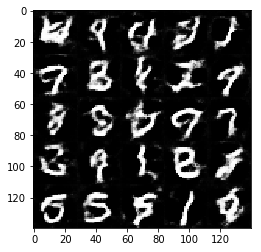

Epoch 1/2... Batch 410... Discriminator Loss: 1.3272... Generator Loss: 0.5582
Epoch 1/2... Batch 420... Discriminator Loss: 1.1162... Generator Loss: 0.8539
Epoch 1/2... Batch 430... Discriminator Loss: 1.0909... Generator Loss: 1.3343
Epoch 1/2... Batch 440... Discriminator Loss: 1.3225... Generator Loss: 0.5777
Epoch 1/2... Batch 450... Discriminator Loss: 1.5955... Generator Loss: 0.3966
Epoch 1/2... Batch 460... Discriminator Loss: 1.1527... Generator Loss: 0.7894
Epoch 1/2... Batch 470... Discriminator Loss: 1.3634... Generator Loss: 0.5116
Epoch 1/2... Batch 480... Discriminator Loss: 1.3127... Generator Loss: 0.6030
Epoch 1/2... Batch 490... Discriminator Loss: 1.0588... Generator Loss: 1.5625
Epoch 1/2... Batch 500... Discriminator Loss: 1.1232... Generator Loss: 0.9970


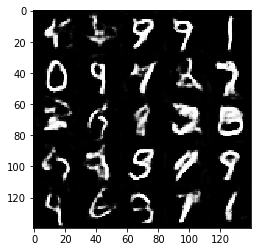

Epoch 1/2... Batch 510... Discriminator Loss: 1.1849... Generator Loss: 0.7142
Epoch 1/2... Batch 520... Discriminator Loss: 1.0317... Generator Loss: 1.1565
Epoch 1/2... Batch 530... Discriminator Loss: 1.4538... Generator Loss: 0.4667
Epoch 1/2... Batch 540... Discriminator Loss: 1.0837... Generator Loss: 0.8390
Epoch 1/2... Batch 550... Discriminator Loss: 1.0026... Generator Loss: 1.1088
Epoch 1/2... Batch 560... Discriminator Loss: 1.2759... Generator Loss: 1.8986
Epoch 1/2... Batch 570... Discriminator Loss: 1.0694... Generator Loss: 1.2721
Epoch 1/2... Batch 580... Discriminator Loss: 1.1551... Generator Loss: 1.3913
Epoch 1/2... Batch 590... Discriminator Loss: 1.1236... Generator Loss: 1.1085
Epoch 1/2... Batch 600... Discriminator Loss: 1.0947... Generator Loss: 1.7306


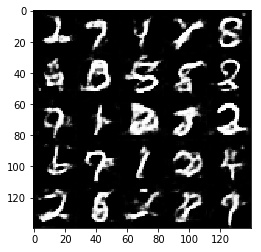

Epoch 1/2... Batch 610... Discriminator Loss: 1.1738... Generator Loss: 1.6705
Epoch 1/2... Batch 620... Discriminator Loss: 0.9807... Generator Loss: 1.0640
Epoch 1/2... Batch 630... Discriminator Loss: 1.0754... Generator Loss: 0.9071
Epoch 1/2... Batch 640... Discriminator Loss: 1.5832... Generator Loss: 0.4164
Epoch 1/2... Batch 650... Discriminator Loss: 1.1307... Generator Loss: 0.7930
Epoch 1/2... Batch 660... Discriminator Loss: 1.1576... Generator Loss: 0.7032
Epoch 1/2... Batch 670... Discriminator Loss: 1.1273... Generator Loss: 0.8615
Epoch 1/2... Batch 680... Discriminator Loss: 0.9508... Generator Loss: 1.2337
Epoch 1/2... Batch 690... Discriminator Loss: 1.0339... Generator Loss: 1.4645
Epoch 1/2... Batch 700... Discriminator Loss: 1.1087... Generator Loss: 0.7897


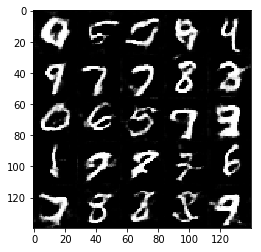

Epoch 1/2... Batch 710... Discriminator Loss: 1.2847... Generator Loss: 1.1085
Epoch 1/2... Batch 720... Discriminator Loss: 0.9781... Generator Loss: 1.1556
Epoch 1/2... Batch 730... Discriminator Loss: 1.2041... Generator Loss: 0.7086
Epoch 1/2... Batch 740... Discriminator Loss: 1.1079... Generator Loss: 0.8314
Epoch 1/2... Batch 750... Discriminator Loss: 1.0841... Generator Loss: 1.8795
Epoch 1/2... Batch 760... Discriminator Loss: 1.0617... Generator Loss: 0.8608
Epoch 1/2... Batch 770... Discriminator Loss: 1.0662... Generator Loss: 0.8460
Epoch 1/2... Batch 780... Discriminator Loss: 0.9348... Generator Loss: 1.2942
Epoch 1/2... Batch 790... Discriminator Loss: 1.2623... Generator Loss: 0.6547
Epoch 1/2... Batch 800... Discriminator Loss: 1.0108... Generator Loss: 1.1233


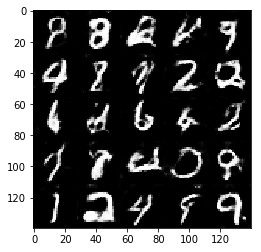

Epoch 1/2... Batch 810... Discriminator Loss: 1.5431... Generator Loss: 1.4625
Epoch 1/2... Batch 820... Discriminator Loss: 0.9309... Generator Loss: 1.2616
Epoch 1/2... Batch 830... Discriminator Loss: 1.3204... Generator Loss: 0.5197
Epoch 1/2... Batch 840... Discriminator Loss: 1.0535... Generator Loss: 0.8738
Epoch 1/2... Batch 850... Discriminator Loss: 1.0696... Generator Loss: 1.5314
Epoch 1/2... Batch 860... Discriminator Loss: 1.1032... Generator Loss: 0.8221
Epoch 1/2... Batch 870... Discriminator Loss: 1.0752... Generator Loss: 0.8039
Epoch 1/2... Batch 880... Discriminator Loss: 1.2053... Generator Loss: 0.7441
Epoch 1/2... Batch 890... Discriminator Loss: 0.9757... Generator Loss: 0.9352
Epoch 1/2... Batch 900... Discriminator Loss: 1.1701... Generator Loss: 1.8715


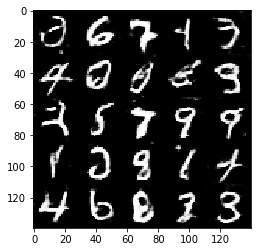

Epoch 1/2... Batch 910... Discriminator Loss: 1.1474... Generator Loss: 0.7312
Epoch 1/2... Batch 920... Discriminator Loss: 1.5590... Generator Loss: 2.0487
Epoch 1/2... Batch 930... Discriminator Loss: 1.3280... Generator Loss: 2.0395
Epoch 2/2... Batch 10... Discriminator Loss: 1.3127... Generator Loss: 0.5921
Epoch 2/2... Batch 20... Discriminator Loss: 0.8445... Generator Loss: 1.4110
Epoch 2/2... Batch 30... Discriminator Loss: 0.9479... Generator Loss: 1.0263
Epoch 2/2... Batch 40... Discriminator Loss: 0.9399... Generator Loss: 1.5028
Epoch 2/2... Batch 50... Discriminator Loss: 1.2854... Generator Loss: 1.8427
Epoch 2/2... Batch 60... Discriminator Loss: 1.2022... Generator Loss: 0.7942
Epoch 2/2... Batch 70... Discriminator Loss: 1.1486... Generator Loss: 0.7931
Epoch 2/2... Batch 80... Discriminator Loss: 1.0135... Generator Loss: 1.0636
Epoch 2/2... Batch 90... Discriminator Loss: 1.0124... Generator Loss: 1.0445
Epoch 2/2... Batch 100... Discriminator Loss: 1.0885... Gener

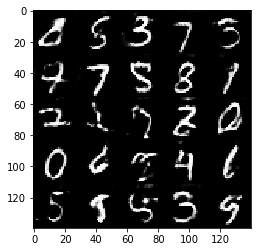

Epoch 2/2... Batch 110... Discriminator Loss: 0.9526... Generator Loss: 1.1751
Epoch 2/2... Batch 120... Discriminator Loss: 1.3472... Generator Loss: 0.5689
Epoch 2/2... Batch 130... Discriminator Loss: 1.3492... Generator Loss: 1.9883
Epoch 2/2... Batch 140... Discriminator Loss: 1.0171... Generator Loss: 0.9763
Epoch 2/2... Batch 150... Discriminator Loss: 1.0082... Generator Loss: 0.9414
Epoch 2/2... Batch 160... Discriminator Loss: 0.9094... Generator Loss: 1.0826
Epoch 2/2... Batch 170... Discriminator Loss: 1.0915... Generator Loss: 1.8481
Epoch 2/2... Batch 180... Discriminator Loss: 1.5163... Generator Loss: 0.4691
Epoch 2/2... Batch 190... Discriminator Loss: 1.1729... Generator Loss: 0.9141
Epoch 2/2... Batch 200... Discriminator Loss: 0.9832... Generator Loss: 1.2880


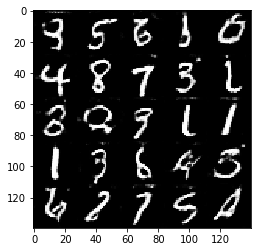

Epoch 2/2... Batch 210... Discriminator Loss: 0.8974... Generator Loss: 1.1422
Epoch 2/2... Batch 220... Discriminator Loss: 1.1127... Generator Loss: 1.3359
Epoch 2/2... Batch 230... Discriminator Loss: 1.1464... Generator Loss: 0.8423
Epoch 2/2... Batch 240... Discriminator Loss: 1.1604... Generator Loss: 1.7239
Epoch 2/2... Batch 250... Discriminator Loss: 1.0045... Generator Loss: 1.3310
Epoch 2/2... Batch 260... Discriminator Loss: 1.0842... Generator Loss: 0.8174
Epoch 2/2... Batch 270... Discriminator Loss: 1.0399... Generator Loss: 1.2353
Epoch 2/2... Batch 280... Discriminator Loss: 0.9450... Generator Loss: 1.1066
Epoch 2/2... Batch 290... Discriminator Loss: 1.4088... Generator Loss: 0.5012
Epoch 2/2... Batch 300... Discriminator Loss: 1.0942... Generator Loss: 1.4697


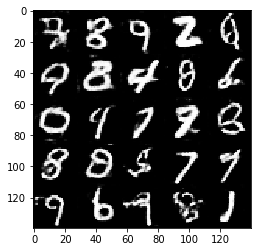

Epoch 2/2... Batch 310... Discriminator Loss: 0.9748... Generator Loss: 1.7092
Epoch 2/2... Batch 320... Discriminator Loss: 1.0671... Generator Loss: 0.8679
Epoch 2/2... Batch 330... Discriminator Loss: 1.0168... Generator Loss: 1.0807
Epoch 2/2... Batch 340... Discriminator Loss: 1.1486... Generator Loss: 0.7092
Epoch 2/2... Batch 350... Discriminator Loss: 0.9945... Generator Loss: 0.9304
Epoch 2/2... Batch 360... Discriminator Loss: 0.8898... Generator Loss: 1.2942
Epoch 2/2... Batch 370... Discriminator Loss: 0.9622... Generator Loss: 1.6500
Epoch 2/2... Batch 380... Discriminator Loss: 1.2197... Generator Loss: 3.6510
Epoch 2/2... Batch 390... Discriminator Loss: 1.1192... Generator Loss: 1.1646
Epoch 2/2... Batch 400... Discriminator Loss: 0.9512... Generator Loss: 1.1560


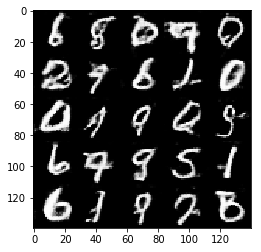

Epoch 2/2... Batch 410... Discriminator Loss: 1.6442... Generator Loss: 0.4097
Epoch 2/2... Batch 420... Discriminator Loss: 1.3102... Generator Loss: 0.5849
Epoch 2/2... Batch 430... Discriminator Loss: 1.1078... Generator Loss: 0.8303
Epoch 2/2... Batch 440... Discriminator Loss: 0.9066... Generator Loss: 1.1837
Epoch 2/2... Batch 450... Discriminator Loss: 1.0447... Generator Loss: 1.0610
Epoch 2/2... Batch 460... Discriminator Loss: 0.8401... Generator Loss: 1.4287
Epoch 2/2... Batch 470... Discriminator Loss: 0.9861... Generator Loss: 1.0382
Epoch 2/2... Batch 480... Discriminator Loss: 1.4443... Generator Loss: 0.5319
Epoch 2/2... Batch 490... Discriminator Loss: 0.8278... Generator Loss: 1.7694
Epoch 2/2... Batch 500... Discriminator Loss: 1.1520... Generator Loss: 2.3943


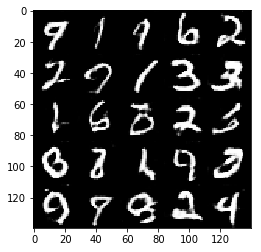

Epoch 2/2... Batch 510... Discriminator Loss: 1.0241... Generator Loss: 0.9592
Epoch 2/2... Batch 520... Discriminator Loss: 1.5312... Generator Loss: 0.4621
Epoch 2/2... Batch 530... Discriminator Loss: 0.8722... Generator Loss: 1.4716
Epoch 2/2... Batch 540... Discriminator Loss: 0.7397... Generator Loss: 1.5665
Epoch 2/2... Batch 550... Discriminator Loss: 0.9129... Generator Loss: 1.2884
Epoch 2/2... Batch 560... Discriminator Loss: 1.5374... Generator Loss: 0.4754
Epoch 2/2... Batch 570... Discriminator Loss: 0.8722... Generator Loss: 1.1734
Epoch 2/2... Batch 580... Discriminator Loss: 0.7991... Generator Loss: 1.5039
Epoch 2/2... Batch 590... Discriminator Loss: 0.8766... Generator Loss: 1.9762
Epoch 2/2... Batch 600... Discriminator Loss: 1.0361... Generator Loss: 1.9485


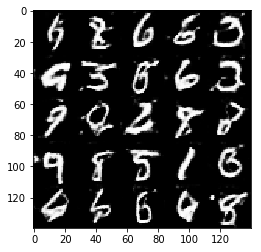

Epoch 2/2... Batch 610... Discriminator Loss: 1.0437... Generator Loss: 1.3726
Epoch 2/2... Batch 620... Discriminator Loss: 1.0645... Generator Loss: 0.8160
Epoch 2/2... Batch 630... Discriminator Loss: 1.1604... Generator Loss: 0.7163
Epoch 2/2... Batch 640... Discriminator Loss: 1.1850... Generator Loss: 0.8804
Epoch 2/2... Batch 650... Discriminator Loss: 1.1927... Generator Loss: 0.7105
Epoch 2/2... Batch 660... Discriminator Loss: 0.9981... Generator Loss: 2.0663
Epoch 2/2... Batch 670... Discriminator Loss: 0.9892... Generator Loss: 1.6777
Epoch 2/2... Batch 680... Discriminator Loss: 1.0492... Generator Loss: 0.8387
Epoch 2/2... Batch 690... Discriminator Loss: 0.8576... Generator Loss: 1.6769
Epoch 2/2... Batch 700... Discriminator Loss: 1.2595... Generator Loss: 0.6405


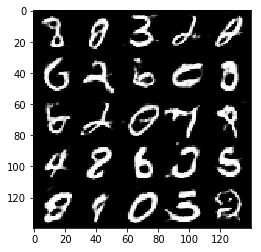

Epoch 2/2... Batch 710... Discriminator Loss: 0.9810... Generator Loss: 1.2104
Epoch 2/2... Batch 720... Discriminator Loss: 0.9021... Generator Loss: 1.1030
Epoch 2/2... Batch 730... Discriminator Loss: 0.9457... Generator Loss: 1.9184
Epoch 2/2... Batch 740... Discriminator Loss: 1.4162... Generator Loss: 0.6020
Epoch 2/2... Batch 750... Discriminator Loss: 0.8126... Generator Loss: 1.5840
Epoch 2/2... Batch 760... Discriminator Loss: 1.0108... Generator Loss: 0.9344
Epoch 2/2... Batch 770... Discriminator Loss: 1.5395... Generator Loss: 0.4825
Epoch 2/2... Batch 780... Discriminator Loss: 1.0102... Generator Loss: 1.7333
Epoch 2/2... Batch 790... Discriminator Loss: 1.8013... Generator Loss: 0.3701
Epoch 2/2... Batch 800... Discriminator Loss: 0.9873... Generator Loss: 0.9911


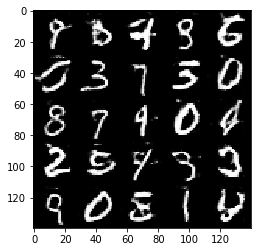

Epoch 2/2... Batch 810... Discriminator Loss: 0.9808... Generator Loss: 1.0924
Epoch 2/2... Batch 820... Discriminator Loss: 0.7943... Generator Loss: 1.3114
Epoch 2/2... Batch 830... Discriminator Loss: 0.9954... Generator Loss: 0.9135
Epoch 2/2... Batch 840... Discriminator Loss: 1.3898... Generator Loss: 0.6321
Epoch 2/2... Batch 850... Discriminator Loss: 0.8833... Generator Loss: 1.1905
Epoch 2/2... Batch 860... Discriminator Loss: 0.8431... Generator Loss: 1.3671
Epoch 2/2... Batch 870... Discriminator Loss: 1.3109... Generator Loss: 0.5674
Epoch 2/2... Batch 880... Discriminator Loss: 0.8685... Generator Loss: 1.6402
Epoch 2/2... Batch 890... Discriminator Loss: 1.8728... Generator Loss: 0.3406
Epoch 2/2... Batch 900... Discriminator Loss: 0.9808... Generator Loss: 1.5669


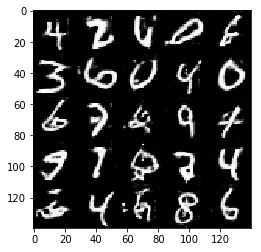

Epoch 2/2... Batch 910... Discriminator Loss: 1.0238... Generator Loss: 0.9353
Epoch 2/2... Batch 920... Discriminator Loss: 0.8102... Generator Loss: 1.5336
Epoch 2/2... Batch 930... Discriminator Loss: 0.8930... Generator Loss: 1.1497


In [20]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 0.6160... Generator Loss: 2.7380
Epoch 1/1... Batch 20... Discriminator Loss: 4.2157... Generator Loss: 0.0536
Epoch 1/1... Batch 30... Discriminator Loss: 1.0787... Generator Loss: 3.5831
Epoch 1/1... Batch 40... Discriminator Loss: 1.0731... Generator Loss: 1.0915
Epoch 1/1... Batch 50... Discriminator Loss: 0.7696... Generator Loss: 4.6479
Epoch 1/1... Batch 60... Discriminator Loss: 0.4553... Generator Loss: 2.7548
Epoch 1/1... Batch 70... Discriminator Loss: 0.4751... Generator Loss: 3.9852
Epoch 1/1... Batch 80... Discriminator Loss: 0.4324... Generator Loss: 3.7996
Epoch 1/1... Batch 90... Discriminator Loss: 1.4458... Generator Loss: 8.4336
Epoch 1/1... Batch 100... Discriminator Loss: 0.5746... Generator Loss: 3.7887


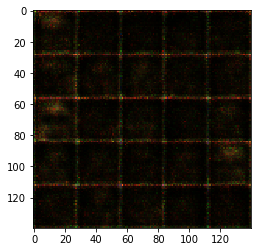

Epoch 1/1... Batch 110... Discriminator Loss: 1.5277... Generator Loss: 4.3454
Epoch 1/1... Batch 120... Discriminator Loss: 0.8290... Generator Loss: 1.3538
Epoch 1/1... Batch 130... Discriminator Loss: 1.5448... Generator Loss: 0.6163
Epoch 1/1... Batch 140... Discriminator Loss: 0.7281... Generator Loss: 3.4222
Epoch 1/1... Batch 150... Discriminator Loss: 0.9799... Generator Loss: 3.5063
Epoch 1/1... Batch 160... Discriminator Loss: 0.9577... Generator Loss: 1.2678
Epoch 1/1... Batch 170... Discriminator Loss: 0.6673... Generator Loss: 2.0850
Epoch 1/1... Batch 180... Discriminator Loss: 0.8849... Generator Loss: 1.2402
Epoch 1/1... Batch 190... Discriminator Loss: 0.8017... Generator Loss: 1.8874
Epoch 1/1... Batch 200... Discriminator Loss: 0.7812... Generator Loss: 1.8734


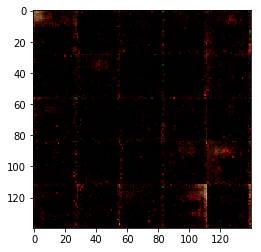

Epoch 1/1... Batch 210... Discriminator Loss: 1.8879... Generator Loss: 0.4387
Epoch 1/1... Batch 220... Discriminator Loss: 0.7024... Generator Loss: 1.8763
Epoch 1/1... Batch 230... Discriminator Loss: 0.8040... Generator Loss: 1.6310
Epoch 1/1... Batch 240... Discriminator Loss: 0.6395... Generator Loss: 1.8681
Epoch 1/1... Batch 250... Discriminator Loss: 0.7877... Generator Loss: 3.6694
Epoch 1/1... Batch 260... Discriminator Loss: 0.9136... Generator Loss: 1.4770
Epoch 1/1... Batch 270... Discriminator Loss: 0.7110... Generator Loss: 1.6524
Epoch 1/1... Batch 280... Discriminator Loss: 1.0638... Generator Loss: 1.3435
Epoch 1/1... Batch 290... Discriminator Loss: 1.0818... Generator Loss: 1.7702
Epoch 1/1... Batch 300... Discriminator Loss: 1.1169... Generator Loss: 0.9045


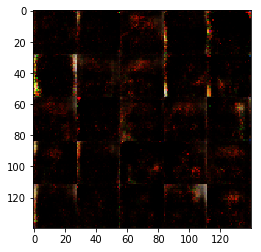

Epoch 1/1... Batch 310... Discriminator Loss: 1.5169... Generator Loss: 0.5131
Epoch 1/1... Batch 320... Discriminator Loss: 0.9629... Generator Loss: 2.3732
Epoch 1/1... Batch 330... Discriminator Loss: 1.2001... Generator Loss: 3.5073
Epoch 1/1... Batch 340... Discriminator Loss: 0.9624... Generator Loss: 2.3414
Epoch 1/1... Batch 350... Discriminator Loss: 0.9835... Generator Loss: 1.5101
Epoch 1/1... Batch 360... Discriminator Loss: 1.1291... Generator Loss: 1.7001
Epoch 1/1... Batch 370... Discriminator Loss: 1.1501... Generator Loss: 0.8737
Epoch 1/1... Batch 380... Discriminator Loss: 1.2120... Generator Loss: 0.7295
Epoch 1/1... Batch 390... Discriminator Loss: 1.4178... Generator Loss: 0.5806
Epoch 1/1... Batch 400... Discriminator Loss: 1.6720... Generator Loss: 0.4759


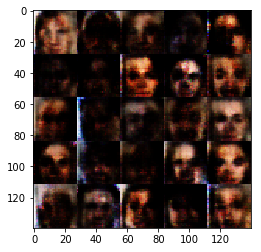

Epoch 1/1... Batch 410... Discriminator Loss: 1.0209... Generator Loss: 1.8587
Epoch 1/1... Batch 420... Discriminator Loss: 0.8851... Generator Loss: 1.2879
Epoch 1/1... Batch 430... Discriminator Loss: 1.1053... Generator Loss: 1.7267
Epoch 1/1... Batch 440... Discriminator Loss: 0.9397... Generator Loss: 1.5638
Epoch 1/1... Batch 450... Discriminator Loss: 1.2252... Generator Loss: 1.6662
Epoch 1/1... Batch 460... Discriminator Loss: 1.0447... Generator Loss: 1.1108
Epoch 1/1... Batch 470... Discriminator Loss: 1.2327... Generator Loss: 0.8789
Epoch 1/1... Batch 480... Discriminator Loss: 1.1048... Generator Loss: 1.0338
Epoch 1/1... Batch 490... Discriminator Loss: 1.2531... Generator Loss: 1.0373
Epoch 1/1... Batch 500... Discriminator Loss: 1.0641... Generator Loss: 0.9445


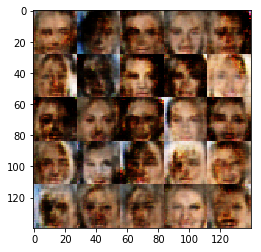

Epoch 1/1... Batch 510... Discriminator Loss: 1.0302... Generator Loss: 1.4167
Epoch 1/1... Batch 520... Discriminator Loss: 1.1898... Generator Loss: 0.8791
Epoch 1/1... Batch 530... Discriminator Loss: 1.2170... Generator Loss: 0.6251
Epoch 1/1... Batch 540... Discriminator Loss: 1.1157... Generator Loss: 1.1371
Epoch 1/1... Batch 550... Discriminator Loss: 1.3440... Generator Loss: 0.8577
Epoch 1/1... Batch 560... Discriminator Loss: 1.1472... Generator Loss: 1.1699
Epoch 1/1... Batch 570... Discriminator Loss: 0.9976... Generator Loss: 1.2657
Epoch 1/1... Batch 580... Discriminator Loss: 1.2467... Generator Loss: 1.5518
Epoch 1/1... Batch 590... Discriminator Loss: 1.2691... Generator Loss: 0.8488
Epoch 1/1... Batch 600... Discriminator Loss: 1.1337... Generator Loss: 1.2345


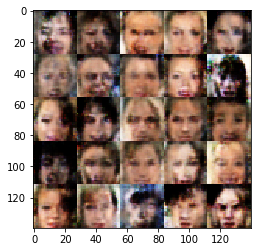

Epoch 1/1... Batch 610... Discriminator Loss: 1.2288... Generator Loss: 0.9226
Epoch 1/1... Batch 620... Discriminator Loss: 1.0685... Generator Loss: 1.0527
Epoch 1/1... Batch 630... Discriminator Loss: 1.1280... Generator Loss: 0.9346
Epoch 1/1... Batch 640... Discriminator Loss: 1.2142... Generator Loss: 0.9056
Epoch 1/1... Batch 650... Discriminator Loss: 1.0607... Generator Loss: 1.1697
Epoch 1/1... Batch 660... Discriminator Loss: 1.2186... Generator Loss: 0.8272
Epoch 1/1... Batch 670... Discriminator Loss: 1.2755... Generator Loss: 0.8195
Epoch 1/1... Batch 680... Discriminator Loss: 1.2435... Generator Loss: 0.8223
Epoch 1/1... Batch 690... Discriminator Loss: 1.0701... Generator Loss: 1.4217
Epoch 1/1... Batch 700... Discriminator Loss: 1.1217... Generator Loss: 0.9408


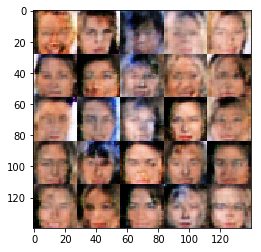

Epoch 1/1... Batch 710... Discriminator Loss: 1.1993... Generator Loss: 1.4430
Epoch 1/1... Batch 720... Discriminator Loss: 1.2647... Generator Loss: 0.9853
Epoch 1/1... Batch 730... Discriminator Loss: 1.3299... Generator Loss: 0.7398
Epoch 1/1... Batch 740... Discriminator Loss: 1.1499... Generator Loss: 0.9385
Epoch 1/1... Batch 750... Discriminator Loss: 1.3848... Generator Loss: 0.8449
Epoch 1/1... Batch 760... Discriminator Loss: 1.1637... Generator Loss: 0.8858
Epoch 1/1... Batch 770... Discriminator Loss: 1.3591... Generator Loss: 0.8667
Epoch 1/1... Batch 780... Discriminator Loss: 1.3468... Generator Loss: 0.7496
Epoch 1/1... Batch 790... Discriminator Loss: 1.2352... Generator Loss: 0.7290
Epoch 1/1... Batch 800... Discriminator Loss: 1.3499... Generator Loss: 1.1033


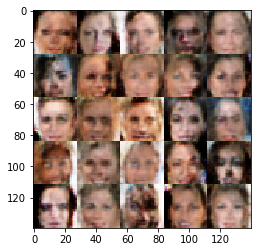

Epoch 1/1... Batch 810... Discriminator Loss: 1.2670... Generator Loss: 0.9835
Epoch 1/1... Batch 820... Discriminator Loss: 1.1668... Generator Loss: 1.3918
Epoch 1/1... Batch 830... Discriminator Loss: 1.2055... Generator Loss: 1.0210
Epoch 1/1... Batch 840... Discriminator Loss: 1.3967... Generator Loss: 0.6635
Epoch 1/1... Batch 850... Discriminator Loss: 1.2513... Generator Loss: 0.8202
Epoch 1/1... Batch 860... Discriminator Loss: 1.2477... Generator Loss: 1.2411
Epoch 1/1... Batch 870... Discriminator Loss: 1.2965... Generator Loss: 0.9435
Epoch 1/1... Batch 880... Discriminator Loss: 1.2348... Generator Loss: 1.0812
Epoch 1/1... Batch 890... Discriminator Loss: 1.3100... Generator Loss: 0.9478
Epoch 1/1... Batch 900... Discriminator Loss: 1.2437... Generator Loss: 0.7833


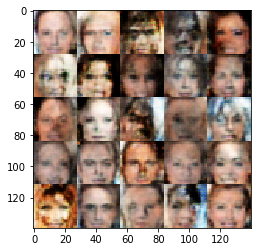

Epoch 1/1... Batch 910... Discriminator Loss: 1.1581... Generator Loss: 1.1491
Epoch 1/1... Batch 920... Discriminator Loss: 1.1523... Generator Loss: 1.1736
Epoch 1/1... Batch 930... Discriminator Loss: 1.2625... Generator Loss: 0.6775
Epoch 1/1... Batch 940... Discriminator Loss: 1.2867... Generator Loss: 0.7478
Epoch 1/1... Batch 950... Discriminator Loss: 1.3260... Generator Loss: 1.1690
Epoch 1/1... Batch 960... Discriminator Loss: 1.2419... Generator Loss: 1.3528
Epoch 1/1... Batch 970... Discriminator Loss: 1.3762... Generator Loss: 0.6776
Epoch 1/1... Batch 980... Discriminator Loss: 1.2944... Generator Loss: 0.8685
Epoch 1/1... Batch 990... Discriminator Loss: 1.2104... Generator Loss: 1.2074
Epoch 1/1... Batch 1000... Discriminator Loss: 1.2407... Generator Loss: 0.6549


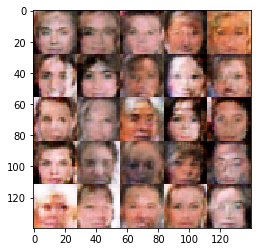

Epoch 1/1... Batch 1010... Discriminator Loss: 1.2275... Generator Loss: 1.0995
Epoch 1/1... Batch 1020... Discriminator Loss: 1.3287... Generator Loss: 0.7203
Epoch 1/1... Batch 1030... Discriminator Loss: 1.2830... Generator Loss: 0.8269
Epoch 1/1... Batch 1040... Discriminator Loss: 1.3245... Generator Loss: 0.7327
Epoch 1/1... Batch 1050... Discriminator Loss: 1.1432... Generator Loss: 0.8842
Epoch 1/1... Batch 1060... Discriminator Loss: 1.2661... Generator Loss: 0.9398
Epoch 1/1... Batch 1070... Discriminator Loss: 1.4202... Generator Loss: 0.6336
Epoch 1/1... Batch 1080... Discriminator Loss: 1.2109... Generator Loss: 0.8143
Epoch 1/1... Batch 1090... Discriminator Loss: 1.2697... Generator Loss: 0.9289
Epoch 1/1... Batch 1100... Discriminator Loss: 1.1201... Generator Loss: 0.9436


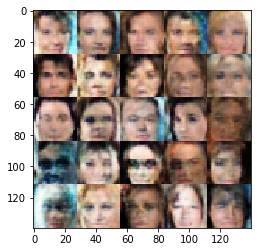

Epoch 1/1... Batch 1110... Discriminator Loss: 1.2883... Generator Loss: 0.8152
Epoch 1/1... Batch 1120... Discriminator Loss: 1.2896... Generator Loss: 0.7903
Epoch 1/1... Batch 1130... Discriminator Loss: 1.2614... Generator Loss: 0.9489
Epoch 1/1... Batch 1140... Discriminator Loss: 1.1902... Generator Loss: 0.7784
Epoch 1/1... Batch 1150... Discriminator Loss: 1.2943... Generator Loss: 1.0985
Epoch 1/1... Batch 1160... Discriminator Loss: 1.1737... Generator Loss: 1.0942
Epoch 1/1... Batch 1170... Discriminator Loss: 1.4574... Generator Loss: 0.7950
Epoch 1/1... Batch 1180... Discriminator Loss: 1.6336... Generator Loss: 0.4300
Epoch 1/1... Batch 1190... Discriminator Loss: 1.4027... Generator Loss: 0.7133
Epoch 1/1... Batch 1200... Discriminator Loss: 1.2955... Generator Loss: 0.6437


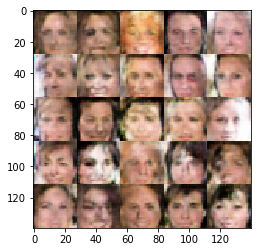

Epoch 1/1... Batch 1210... Discriminator Loss: 1.2098... Generator Loss: 1.0527
Epoch 1/1... Batch 1220... Discriminator Loss: 1.2089... Generator Loss: 1.0287
Epoch 1/1... Batch 1230... Discriminator Loss: 1.2330... Generator Loss: 0.8775
Epoch 1/1... Batch 1240... Discriminator Loss: 1.2755... Generator Loss: 0.7775
Epoch 1/1... Batch 1250... Discriminator Loss: 1.2120... Generator Loss: 1.1653
Epoch 1/1... Batch 1260... Discriminator Loss: 1.1681... Generator Loss: 0.8612
Epoch 1/1... Batch 1270... Discriminator Loss: 1.1380... Generator Loss: 1.1358
Epoch 1/1... Batch 1280... Discriminator Loss: 1.3891... Generator Loss: 1.1085
Epoch 1/1... Batch 1290... Discriminator Loss: 1.2016... Generator Loss: 1.0604
Epoch 1/1... Batch 1300... Discriminator Loss: 1.3198... Generator Loss: 1.1286


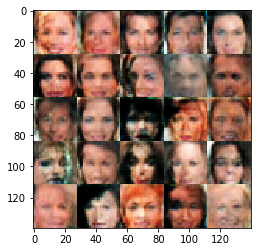

Epoch 1/1... Batch 1310... Discriminator Loss: 1.1671... Generator Loss: 1.2117
Epoch 1/1... Batch 1320... Discriminator Loss: 1.2589... Generator Loss: 0.9223
Epoch 1/1... Batch 1330... Discriminator Loss: 1.3465... Generator Loss: 0.9026
Epoch 1/1... Batch 1340... Discriminator Loss: 1.2348... Generator Loss: 0.7994
Epoch 1/1... Batch 1350... Discriminator Loss: 1.1266... Generator Loss: 0.8873
Epoch 1/1... Batch 1360... Discriminator Loss: 1.2912... Generator Loss: 1.3286
Epoch 1/1... Batch 1370... Discriminator Loss: 1.1795... Generator Loss: 0.8098
Epoch 1/1... Batch 1380... Discriminator Loss: 1.1842... Generator Loss: 0.8263
Epoch 1/1... Batch 1390... Discriminator Loss: 1.2455... Generator Loss: 0.7349
Epoch 1/1... Batch 1400... Discriminator Loss: 1.2752... Generator Loss: 0.6420


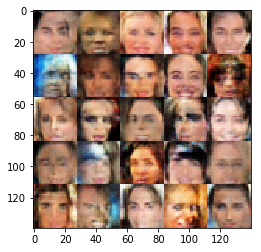

Epoch 1/1... Batch 1410... Discriminator Loss: 1.1749... Generator Loss: 0.7985
Epoch 1/1... Batch 1420... Discriminator Loss: 1.1705... Generator Loss: 1.0402
Epoch 1/1... Batch 1430... Discriminator Loss: 1.2862... Generator Loss: 0.8612
Epoch 1/1... Batch 1440... Discriminator Loss: 1.2423... Generator Loss: 0.9852
Epoch 1/1... Batch 1450... Discriminator Loss: 1.2258... Generator Loss: 1.0338
Epoch 1/1... Batch 1460... Discriminator Loss: 1.4411... Generator Loss: 1.2159
Epoch 1/1... Batch 1470... Discriminator Loss: 1.2105... Generator Loss: 0.9359
Epoch 1/1... Batch 1480... Discriminator Loss: 1.3311... Generator Loss: 0.8163
Epoch 1/1... Batch 1490... Discriminator Loss: 1.3211... Generator Loss: 0.7209
Epoch 1/1... Batch 1500... Discriminator Loss: 1.2175... Generator Loss: 1.1210


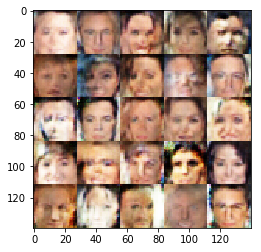

Epoch 1/1... Batch 1510... Discriminator Loss: 1.2557... Generator Loss: 0.9066
Epoch 1/1... Batch 1520... Discriminator Loss: 1.1236... Generator Loss: 1.0201
Epoch 1/1... Batch 1530... Discriminator Loss: 1.3616... Generator Loss: 1.3892
Epoch 1/1... Batch 1540... Discriminator Loss: 1.2762... Generator Loss: 0.8633
Epoch 1/1... Batch 1550... Discriminator Loss: 1.3043... Generator Loss: 0.8566
Epoch 1/1... Batch 1560... Discriminator Loss: 1.3341... Generator Loss: 0.7268
Epoch 1/1... Batch 1570... Discriminator Loss: 1.2369... Generator Loss: 0.7308
Epoch 1/1... Batch 1580... Discriminator Loss: 1.3250... Generator Loss: 0.8319
Epoch 1/1... Batch 1590... Discriminator Loss: 1.3643... Generator Loss: 1.0482
Epoch 1/1... Batch 1600... Discriminator Loss: 1.1799... Generator Loss: 0.9066


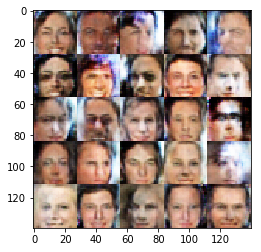

Epoch 1/1... Batch 1610... Discriminator Loss: 1.2675... Generator Loss: 0.7885
Epoch 1/1... Batch 1620... Discriminator Loss: 1.1656... Generator Loss: 0.9226
Epoch 1/1... Batch 1630... Discriminator Loss: 1.0907... Generator Loss: 1.1035
Epoch 1/1... Batch 1640... Discriminator Loss: 1.2823... Generator Loss: 0.8543
Epoch 1/1... Batch 1650... Discriminator Loss: 1.1281... Generator Loss: 1.3836
Epoch 1/1... Batch 1660... Discriminator Loss: 1.2796... Generator Loss: 0.8782
Epoch 1/1... Batch 1670... Discriminator Loss: 1.2050... Generator Loss: 0.9959
Epoch 1/1... Batch 1680... Discriminator Loss: 1.2390... Generator Loss: 1.3520
Epoch 1/1... Batch 1690... Discriminator Loss: 1.1266... Generator Loss: 1.1263
Epoch 1/1... Batch 1700... Discriminator Loss: 1.2115... Generator Loss: 1.4075


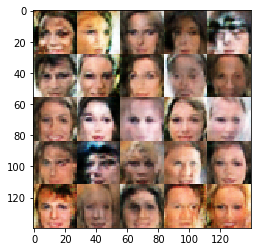

Epoch 1/1... Batch 1710... Discriminator Loss: 1.1805... Generator Loss: 1.4210
Epoch 1/1... Batch 1720... Discriminator Loss: 1.3708... Generator Loss: 1.2660
Epoch 1/1... Batch 1730... Discriminator Loss: 1.1392... Generator Loss: 1.0503
Epoch 1/1... Batch 1740... Discriminator Loss: 1.2962... Generator Loss: 0.8112
Epoch 1/1... Batch 1750... Discriminator Loss: 1.3150... Generator Loss: 1.3595
Epoch 1/1... Batch 1760... Discriminator Loss: 1.1205... Generator Loss: 1.0213
Epoch 1/1... Batch 1770... Discriminator Loss: 1.3093... Generator Loss: 0.8384
Epoch 1/1... Batch 1780... Discriminator Loss: 1.2982... Generator Loss: 0.7172
Epoch 1/1... Batch 1790... Discriminator Loss: 1.2951... Generator Loss: 1.0005
Epoch 1/1... Batch 1800... Discriminator Loss: 1.1377... Generator Loss: 1.0963


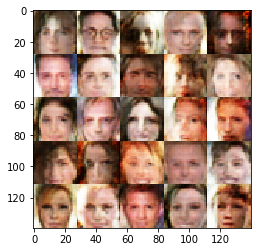

Epoch 1/1... Batch 1810... Discriminator Loss: 1.3215... Generator Loss: 0.6876
Epoch 1/1... Batch 1820... Discriminator Loss: 1.2933... Generator Loss: 0.7347
Epoch 1/1... Batch 1830... Discriminator Loss: 1.3604... Generator Loss: 0.8483
Epoch 1/1... Batch 1840... Discriminator Loss: 1.3508... Generator Loss: 0.7155
Epoch 1/1... Batch 1850... Discriminator Loss: 1.0847... Generator Loss: 1.3911
Epoch 1/1... Batch 1860... Discriminator Loss: 1.2365... Generator Loss: 0.8867
Epoch 1/1... Batch 1870... Discriminator Loss: 1.2435... Generator Loss: 1.3910
Epoch 1/1... Batch 1880... Discriminator Loss: 1.2502... Generator Loss: 0.7994
Epoch 1/1... Batch 1890... Discriminator Loss: 1.3128... Generator Loss: 0.9631
Epoch 1/1... Batch 1900... Discriminator Loss: 1.3166... Generator Loss: 0.8825


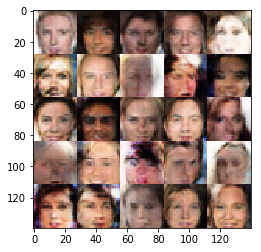

Epoch 1/1... Batch 1910... Discriminator Loss: 1.1093... Generator Loss: 0.9942
Epoch 1/1... Batch 1920... Discriminator Loss: 1.3089... Generator Loss: 0.7478
Epoch 1/1... Batch 1930... Discriminator Loss: 1.3682... Generator Loss: 0.9491
Epoch 1/1... Batch 1940... Discriminator Loss: 1.4224... Generator Loss: 0.7214
Epoch 1/1... Batch 1950... Discriminator Loss: 1.1974... Generator Loss: 1.0459
Epoch 1/1... Batch 1960... Discriminator Loss: 1.3039... Generator Loss: 1.2292
Epoch 1/1... Batch 1970... Discriminator Loss: 1.2153... Generator Loss: 1.0939
Epoch 1/1... Batch 1980... Discriminator Loss: 1.3181... Generator Loss: 0.7321
Epoch 1/1... Batch 1990... Discriminator Loss: 1.1660... Generator Loss: 0.9083
Epoch 1/1... Batch 2000... Discriminator Loss: 1.2335... Generator Loss: 0.7959


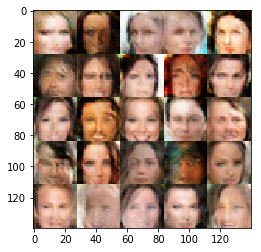

Epoch 1/1... Batch 2010... Discriminator Loss: 1.2311... Generator Loss: 0.8083
Epoch 1/1... Batch 2020... Discriminator Loss: 1.4432... Generator Loss: 0.5132
Epoch 1/1... Batch 2030... Discriminator Loss: 1.1963... Generator Loss: 1.0376
Epoch 1/1... Batch 2040... Discriminator Loss: 1.2476... Generator Loss: 1.0073
Epoch 1/1... Batch 2050... Discriminator Loss: 1.2833... Generator Loss: 1.0088
Epoch 1/1... Batch 2060... Discriminator Loss: 1.1851... Generator Loss: 1.0413
Epoch 1/1... Batch 2070... Discriminator Loss: 1.1129... Generator Loss: 0.9618
Epoch 1/1... Batch 2080... Discriminator Loss: 1.2250... Generator Loss: 0.7432
Epoch 1/1... Batch 2090... Discriminator Loss: 1.3140... Generator Loss: 0.6760
Epoch 1/1... Batch 2100... Discriminator Loss: 1.2752... Generator Loss: 0.8354


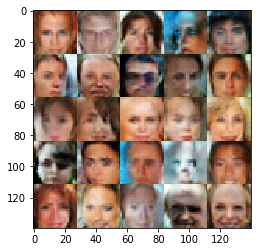

Epoch 1/1... Batch 2110... Discriminator Loss: 1.3199... Generator Loss: 1.3117
Epoch 1/1... Batch 2120... Discriminator Loss: 1.2088... Generator Loss: 1.0265
Epoch 1/1... Batch 2130... Discriminator Loss: 1.2105... Generator Loss: 0.9668
Epoch 1/1... Batch 2140... Discriminator Loss: 1.2314... Generator Loss: 0.7775
Epoch 1/1... Batch 2150... Discriminator Loss: 1.4079... Generator Loss: 0.8070
Epoch 1/1... Batch 2160... Discriminator Loss: 1.1094... Generator Loss: 1.4783
Epoch 1/1... Batch 2170... Discriminator Loss: 1.2834... Generator Loss: 0.7606
Epoch 1/1... Batch 2180... Discriminator Loss: 1.3477... Generator Loss: 0.6613
Epoch 1/1... Batch 2190... Discriminator Loss: 1.2433... Generator Loss: 1.0589
Epoch 1/1... Batch 2200... Discriminator Loss: 1.4095... Generator Loss: 0.7851


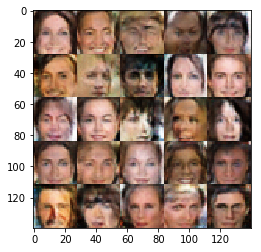

Epoch 1/1... Batch 2210... Discriminator Loss: 1.2025... Generator Loss: 1.1810
Epoch 1/1... Batch 2220... Discriminator Loss: 1.2853... Generator Loss: 0.7586
Epoch 1/1... Batch 2230... Discriminator Loss: 1.2069... Generator Loss: 1.1000
Epoch 1/1... Batch 2240... Discriminator Loss: 1.2382... Generator Loss: 0.7700
Epoch 1/1... Batch 2250... Discriminator Loss: 1.3622... Generator Loss: 0.7013
Epoch 1/1... Batch 2260... Discriminator Loss: 1.2348... Generator Loss: 0.8922
Epoch 1/1... Batch 2270... Discriminator Loss: 1.2576... Generator Loss: 0.8827
Epoch 1/1... Batch 2280... Discriminator Loss: 1.3000... Generator Loss: 0.7573
Epoch 1/1... Batch 2290... Discriminator Loss: 1.3188... Generator Loss: 0.8381
Epoch 1/1... Batch 2300... Discriminator Loss: 1.0740... Generator Loss: 1.1390


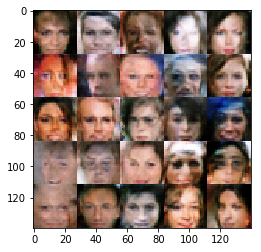

Epoch 1/1... Batch 2310... Discriminator Loss: 1.2225... Generator Loss: 0.7971
Epoch 1/1... Batch 2320... Discriminator Loss: 1.2328... Generator Loss: 0.8842
Epoch 1/1... Batch 2330... Discriminator Loss: 1.4138... Generator Loss: 0.8682
Epoch 1/1... Batch 2340... Discriminator Loss: 1.3808... Generator Loss: 0.8180
Epoch 1/1... Batch 2350... Discriminator Loss: 1.2472... Generator Loss: 1.0724
Epoch 1/1... Batch 2360... Discriminator Loss: 1.2006... Generator Loss: 0.7615
Epoch 1/1... Batch 2370... Discriminator Loss: 1.4337... Generator Loss: 0.5333
Epoch 1/1... Batch 2380... Discriminator Loss: 1.1896... Generator Loss: 1.2145
Epoch 1/1... Batch 2390... Discriminator Loss: 1.1100... Generator Loss: 1.0485
Epoch 1/1... Batch 2400... Discriminator Loss: 1.1415... Generator Loss: 1.1817


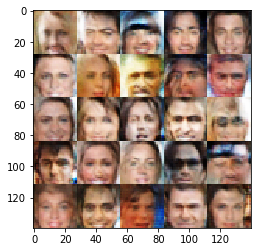

Epoch 1/1... Batch 2410... Discriminator Loss: 1.3570... Generator Loss: 0.8094
Epoch 1/1... Batch 2420... Discriminator Loss: 1.2306... Generator Loss: 0.7423
Epoch 1/1... Batch 2430... Discriminator Loss: 1.1942... Generator Loss: 0.9224
Epoch 1/1... Batch 2440... Discriminator Loss: 1.3772... Generator Loss: 1.1399
Epoch 1/1... Batch 2450... Discriminator Loss: 1.3184... Generator Loss: 1.2344
Epoch 1/1... Batch 2460... Discriminator Loss: 1.3293... Generator Loss: 0.7201
Epoch 1/1... Batch 2470... Discriminator Loss: 1.3339... Generator Loss: 0.8573
Epoch 1/1... Batch 2480... Discriminator Loss: 1.2872... Generator Loss: 0.8976
Epoch 1/1... Batch 2490... Discriminator Loss: 1.1961... Generator Loss: 0.8604
Epoch 1/1... Batch 2500... Discriminator Loss: 1.2080... Generator Loss: 1.2754


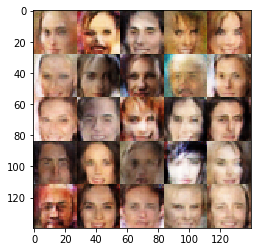

Epoch 1/1... Batch 2510... Discriminator Loss: 1.2238... Generator Loss: 0.9675
Epoch 1/1... Batch 2520... Discriminator Loss: 1.2847... Generator Loss: 0.9962
Epoch 1/1... Batch 2530... Discriminator Loss: 1.2590... Generator Loss: 0.9588
Epoch 1/1... Batch 2540... Discriminator Loss: 1.3973... Generator Loss: 0.7768
Epoch 1/1... Batch 2550... Discriminator Loss: 1.1817... Generator Loss: 1.1659
Epoch 1/1... Batch 2560... Discriminator Loss: 1.1551... Generator Loss: 0.8338
Epoch 1/1... Batch 2570... Discriminator Loss: 1.2070... Generator Loss: 0.9554
Epoch 1/1... Batch 2580... Discriminator Loss: 1.1247... Generator Loss: 1.1504
Epoch 1/1... Batch 2590... Discriminator Loss: 1.2348... Generator Loss: 1.0824
Epoch 1/1... Batch 2600... Discriminator Loss: 1.3570... Generator Loss: 0.7446


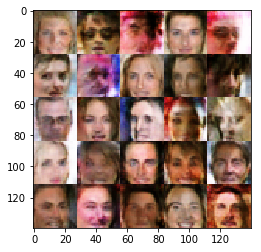

Epoch 1/1... Batch 2610... Discriminator Loss: 1.3914... Generator Loss: 0.6170
Epoch 1/1... Batch 2620... Discriminator Loss: 1.2691... Generator Loss: 0.9206
Epoch 1/1... Batch 2630... Discriminator Loss: 1.2719... Generator Loss: 0.9197
Epoch 1/1... Batch 2640... Discriminator Loss: 1.3059... Generator Loss: 0.8561
Epoch 1/1... Batch 2650... Discriminator Loss: 1.1483... Generator Loss: 1.1031
Epoch 1/1... Batch 2660... Discriminator Loss: 1.2506... Generator Loss: 0.8394
Epoch 1/1... Batch 2670... Discriminator Loss: 1.2715... Generator Loss: 0.8921
Epoch 1/1... Batch 2680... Discriminator Loss: 1.1463... Generator Loss: 0.9659
Epoch 1/1... Batch 2690... Discriminator Loss: 1.2505... Generator Loss: 0.8125
Epoch 1/1... Batch 2700... Discriminator Loss: 1.3586... Generator Loss: 0.7315


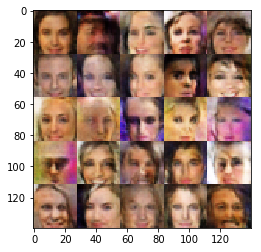

Epoch 1/1... Batch 2710... Discriminator Loss: 1.3325... Generator Loss: 1.2241
Epoch 1/1... Batch 2720... Discriminator Loss: 1.2790... Generator Loss: 0.7907
Epoch 1/1... Batch 2730... Discriminator Loss: 1.3145... Generator Loss: 0.9355
Epoch 1/1... Batch 2740... Discriminator Loss: 1.2136... Generator Loss: 0.8723
Epoch 1/1... Batch 2750... Discriminator Loss: 1.2727... Generator Loss: 0.8298
Epoch 1/1... Batch 2760... Discriminator Loss: 1.3521... Generator Loss: 0.8395
Epoch 1/1... Batch 2770... Discriminator Loss: 1.2930... Generator Loss: 0.9851
Epoch 1/1... Batch 2780... Discriminator Loss: 1.2429... Generator Loss: 0.9096
Epoch 1/1... Batch 2790... Discriminator Loss: 1.1995... Generator Loss: 1.1645
Epoch 1/1... Batch 2800... Discriminator Loss: 1.3098... Generator Loss: 0.6490


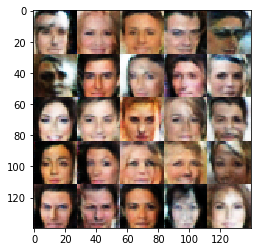

Epoch 1/1... Batch 2810... Discriminator Loss: 1.2159... Generator Loss: 0.9901
Epoch 1/1... Batch 2820... Discriminator Loss: 1.2158... Generator Loss: 1.1370
Epoch 1/1... Batch 2830... Discriminator Loss: 1.1956... Generator Loss: 1.1765
Epoch 1/1... Batch 2840... Discriminator Loss: 1.1947... Generator Loss: 0.8442
Epoch 1/1... Batch 2850... Discriminator Loss: 1.2998... Generator Loss: 0.8821
Epoch 1/1... Batch 2860... Discriminator Loss: 1.2129... Generator Loss: 1.0017
Epoch 1/1... Batch 2870... Discriminator Loss: 1.3281... Generator Loss: 0.8470
Epoch 1/1... Batch 2880... Discriminator Loss: 1.2958... Generator Loss: 1.0502
Epoch 1/1... Batch 2890... Discriminator Loss: 1.1575... Generator Loss: 1.0258
Epoch 1/1... Batch 2900... Discriminator Loss: 1.4348... Generator Loss: 0.6018


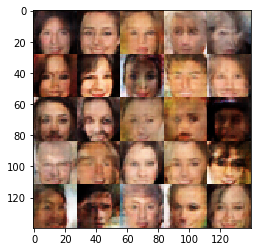

Epoch 1/1... Batch 2910... Discriminator Loss: 1.3633... Generator Loss: 0.5949
Epoch 1/1... Batch 2920... Discriminator Loss: 1.2033... Generator Loss: 0.9211
Epoch 1/1... Batch 2930... Discriminator Loss: 1.1969... Generator Loss: 0.9818
Epoch 1/1... Batch 2940... Discriminator Loss: 1.3277... Generator Loss: 1.1438
Epoch 1/1... Batch 2950... Discriminator Loss: 1.2423... Generator Loss: 0.9261
Epoch 1/1... Batch 2960... Discriminator Loss: 1.2091... Generator Loss: 1.1370
Epoch 1/1... Batch 2970... Discriminator Loss: 1.2908... Generator Loss: 0.7403
Epoch 1/1... Batch 2980... Discriminator Loss: 1.2349... Generator Loss: 0.9619
Epoch 1/1... Batch 2990... Discriminator Loss: 1.3423... Generator Loss: 0.7479
Epoch 1/1... Batch 3000... Discriminator Loss: 1.2249... Generator Loss: 0.8482


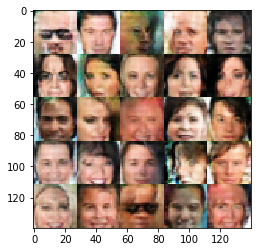

Epoch 1/1... Batch 3010... Discriminator Loss: 1.1685... Generator Loss: 1.2508
Epoch 1/1... Batch 3020... Discriminator Loss: 1.4586... Generator Loss: 0.6659
Epoch 1/1... Batch 3030... Discriminator Loss: 1.3791... Generator Loss: 0.6536
Epoch 1/1... Batch 3040... Discriminator Loss: 1.3592... Generator Loss: 0.8059
Epoch 1/1... Batch 3050... Discriminator Loss: 1.3453... Generator Loss: 0.7209
Epoch 1/1... Batch 3060... Discriminator Loss: 1.1374... Generator Loss: 1.0634
Epoch 1/1... Batch 3070... Discriminator Loss: 1.1762... Generator Loss: 0.9602
Epoch 1/1... Batch 3080... Discriminator Loss: 1.3332... Generator Loss: 0.8463
Epoch 1/1... Batch 3090... Discriminator Loss: 1.1827... Generator Loss: 1.1277
Epoch 1/1... Batch 3100... Discriminator Loss: 1.0910... Generator Loss: 0.9826


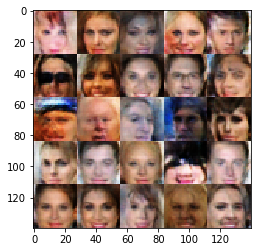

Epoch 1/1... Batch 3110... Discriminator Loss: 1.2757... Generator Loss: 0.7559
Epoch 1/1... Batch 3120... Discriminator Loss: 1.1504... Generator Loss: 1.0709
Epoch 1/1... Batch 3130... Discriminator Loss: 1.3053... Generator Loss: 0.7585
Epoch 1/1... Batch 3140... Discriminator Loss: 1.1742... Generator Loss: 1.0233
Epoch 1/1... Batch 3150... Discriminator Loss: 1.2702... Generator Loss: 0.8240
Epoch 1/1... Batch 3160... Discriminator Loss: 1.1039... Generator Loss: 1.1556


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.